Ce cahier numérique est à disposition sous licence CC-BY-NC-SA. Il a été écrit par Martin Vérot pour les étudiants en L3 de l'ENS de Lyon au sein du département Sciences de la matière. Cette activité vient en complément du [polycopié de cours](http://agregationchimie.free.fr/cours.php#incertitudes). Cette activité s'inspire d'un document fait par Paul Fleurat-Lessard, et de l'article suivant : [Error Analysis Using the Variance-Covariance Matrix
](https://pubs.acs.org/doi/10.1021/ed077p1239)


[Droite de calibration](#calib)
* [incertitude sur y](#incery)
* [Petite vérification du calcul de l'incertitude sur $a$](#verif)
* [Prédiction à partir d'une gamme étalon](#predic)


<span id="calib"></span>
# Droite de calibration

On se place dans le cas d'une droite de calibration ne passant pass forcément par l'origine. On a la mesure des points $x_i$ et $y_i$.

[ 4.          4.66666667  5.33333333  6.          6.66666667  7.33333333
  8.          8.66666667  9.33333333 10.        ]
[16.54162394 19.14220451 21.24755921 23.68882484 25.33159224 28.2829796
 30.99247877 32.98404903 35.01811141 37.04145037]


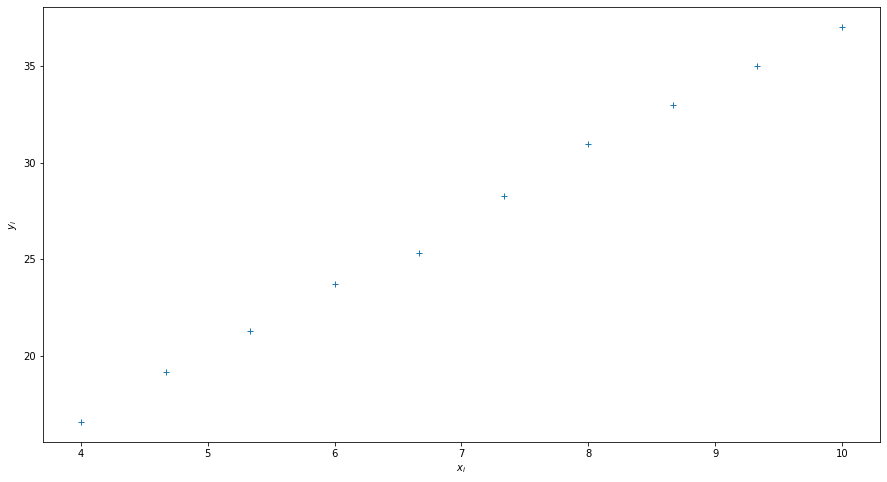

In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt

x_i = np.linspace(4,10,10)
y_i = 3.5 * x_i + stats.norm.rvs(0,0.3,x_i.size)+2.5
print(x_i)
print(y_i)
#tracé des points correspondants
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(1, 1,hspace=0.25)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(x_i,y_i,marker='+',ls='')
ax1.set_xlabel('$x_i$')
ax1.set_ylabel('$y_i$')
plt.show()

On va maintenant effectuer la régression linéaire et calculer les incertitudes sur $a$ et $b$. Ici, la fonction de python va estimer $u_{y_i}$ en supposant que les résidus sont normalement distribués en utilisant la formule suivante du polycopié :
$$\sigma_y=\sqrt{\dfrac{1}{n-2}\sum_i \left( y_i-A×x-B \right)^{2}}=\sqrt{\dfrac{1}{n-2}\chi'^{2}}$$

In [2]:
#régression linéaire
res = stats.linregress(x_i, y_i)
a,b,r,p,ua=res

from packaging import version
#on affiche l'incertitude sur l'ordonnée à l'origine uniquement pour les versions pas trop vieilles de scipy
if version.parse(scipy. __version__) > version.parse('1.6') :
    #il manque l'incertitude sur l'ordonnée à l'origine pour les versions de scipy inférieures à 1.6
    ub=res.intercept_stderr
    print('a : {} u_a {}\nb : {} u_b {}'.format(a,ua,b,ub))
else:
    print('a : {} u_a {}\nb : {} '.format(a,ua,b))

a : 3.4470416764484786 u_a 0.05196218576050797
b : 2.8977956581327255 u_b 0.37709895356679124


In [3]:
#calcul de l'incertitude sur les y à partir des points (incertitude supposée inconnue mais constante,
# si l'incertitude est connue, c'est encore plus direct.
u_yi = np.std(y_i-a*x_i-b,ddof=2)
u_moyy = u_yi/np.sqrt(y_i.size)
print('incertitude-type sur y {}, sur la moyenne des y_i {} '.format(u_yi,u_moyy) )

incertitude-type sur y 0.31464666023496396, sur la moyenne des y_i 0.09950001045076168 


On va maintenant pouvoir calculer l'incertitude sur l'ensemble des mesures pour avoir l'enveloppe correspondante. On utilise l'équation suivante :
$$u_y^2 = \left(u_{a} (x-\overline{x_i})  \right)^{2} + u_{\overline{y_i}}^2 $$


In [4]:
#valeurs de x pour lesquels on va calculer l'enveloppe
xs = np.linspace(0,10,500)
#calcul de la moyenne des x_i
moyx=np.average(x_i)
#calcul de la variance des y associés
vary = (ua*(xs-moyx))**2 + u_moyy**2
#on repasse à l'écart-type
uys=np.sqrt(vary)
#calcul des valeurs correspondant à la modélisation
ys = a*xs+b

On va maintenant tracer les droites correspondante en prenant une loi de Student associée à un intervalle de confiance de 95 %.
<span id="incery"></span>

In [5]:
#ici, le nombre de degrés de liberté est égal à n-2 car on a déja lié nos n valeurs à A et B
facteurStudent = stats.t.interval(0.95,y_i.size-2)[1]

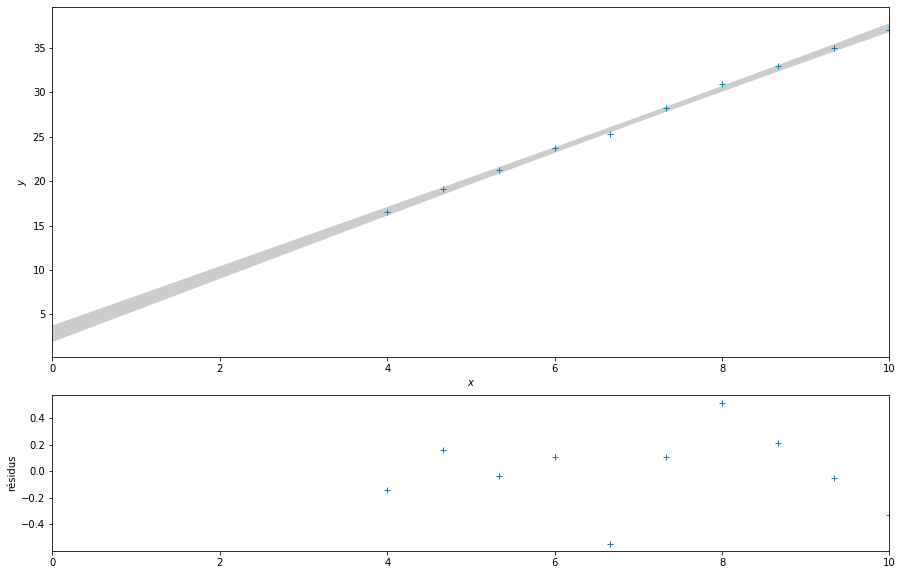

In [6]:
#tracé des points correspondants
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(3, 1,hspace=0.25)
ax1 = fig.add_subplot(gs[0:2,0])
#points de la gamme étalon
ax1.plot(x_i,y_i,marker='+',ls='')
#points de la modélisation
ax1.plot(xs,ys,marker='',ls='')
#intervalle donnant l'incertitude associée au modèle.
ax1.fill_between(xs, ys-facteurStudent*uys,ys+facteurStudent*uys,color='#cccccc')
ax1.set_xlim(np.min(xs),np.max(xs))
ax1.set_ylabel('$y$')
ax1.set_xlabel('$x$')
#résidus
ax2 = fig.add_subplot(gs[2,0])
ax2.plot(x_i,y_i-a*x_i-b,marker='+',ls='')
ax2.set_xlim(np.min(xs),np.max(xs))
ax2.set_ylabel('résidus')
plt.show()

On voit bien l'allure quadratique de l'incertitude associée au modèle et que l'incertitude est d'autant plus grande que l'on s'éloigne de la valeur moyenne des points utilisés pour faire la gamme étalon.

<span id="vérif"></span>
## Petite vérification du calcul de l'incertitude sur $a$

Ici, la formule utilisée par python pour calculer l'incertitude sur $a$ n'étant pas forcément des plus explicites, on peut la comparer à celle calculée de manière plus explicite et vérifier s'il y  concordance.

$$u_a = u_y \sqrt{ \dfrac{1}{\sum_i (x_i - \overline{x_i})^2} }$$

In [7]:
print('incertitude calculée avec linregress  : ua {}'.format(ua))
#ici, on va faire le calcul explicite en prenant l'incertitude type associée au y_i tel que formulée ci-dessus
u_yi = np.std(y_i-a*x_i-b,ddof=2)
#les deux formules ci-dessous sont équivalentes.
ua_man = np.sqrt(u_yi**2 /np.sum((x_i-moyx)**2) ) 
ua_man = np.sqrt( u_yi**2 /(np.var(x_i)*x_i.size) )
print('incertitude calculée explicitement    : ua {}'.format(ua_man))
print('écart entre les deux valeurs : {}'.format(ua-ua_man))

incertitude calculée avec linregress  : ua 0.05196218576050797
incertitude calculée explicitement    : ua 0.05196218576050811
écart entre les deux valeurs : -1.3877787807814457e-16


## Si les incertitudes sur les $y_i$ sont déjà connues
Il faut alors calculer à la main les incertitudes comme ci-dessus avec la valeur connue de $u_y$.

In [8]:
#ici, on va faire le calcul explicite en prenant l'incertitude type associée au y_i tel que formulée ci-dessus
u_yi = 0.3
ua_man = np.sqrt(u_yi**2 /np.sum((x_i-moyx)**2) ) 

<span id="predic"></span>
#   Prédiction à partir d'une gamme étalon

Une fois la gamme étalon établie, on va maintenant s'en servir pour inverser la relation et en sortir la valeur de $x^0$ à partir d'une mesure $y^0$.

In [9]:
#valeurs mesurées de y0
y0s = np.linspace(0,40,501)

#Valeurs de x0 déduite des y0
x0s = (y0s-b)/a

u_yi = np.std(y_i-a*x_i-b,ddof=2)
# ici, on prend l'incertitude sur y_0 de l'ordre de celle calculée sur les y_i, 
#nombre de mesures effectuées pour mesurer y^0
p = 1
# si on fait une moyenne sur p mesures, il est possible de faire tendre cette incertitude vers zéro

u_y0 = u_yi / np.sqrt(p)
#On calcule l'incertitude type
varx0s =  u_y0**2/a**2 + u_yi**2 / (y_i.size*a**2) + ((y0s-np.average(y_i))/a**2 )**2*u_yi**2/np.sum((x_i-np.average(x_i))**2)
ux0s = np.sqrt(varx0s)

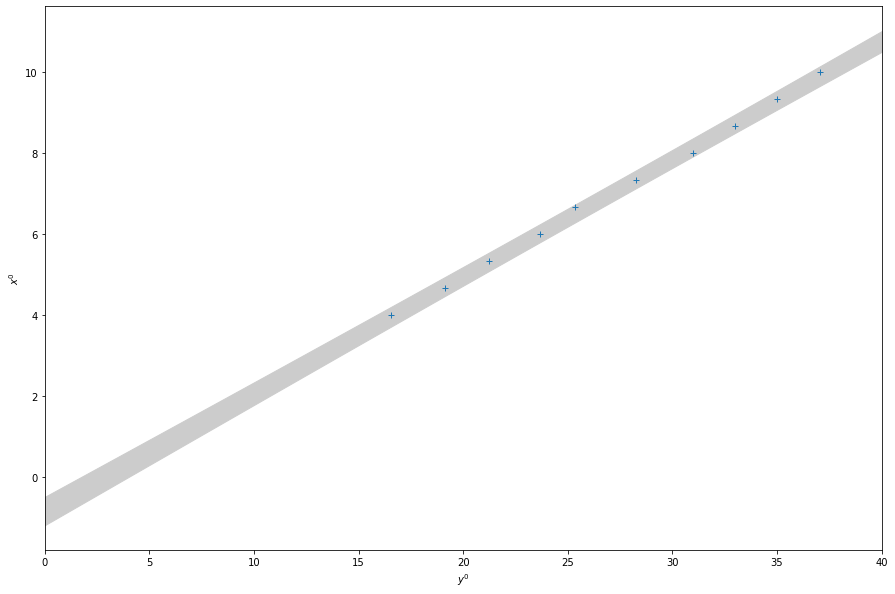

In [10]:
#tracé des points correspondants
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1, 1,hspace=0.25)
ax1 = fig.add_subplot(gs[0,0])
#points de la gamme étalon
ax1.plot(y_i,x_i,marker='+',ls='')
#points de la modélisation
ax1.plot(y0s,x0s,marker='',ls='')
#intervalle donnant l'incertitude associée au modèle.
ax1.fill_between(y0s, x0s-facteurStudent*ux0s,x0s+facteurStudent*ux0s,color='#cccccc')
ax1.set_xlim(np.min(y0s),np.max(y0s))
ax1.set_xlabel('$y^0$')
ax1.set_ylabel('$x^0$')
plt.show()

On peut tracer la contribution des trois termes pour identifier le terme prépondérant dans la variance de $x^0$.

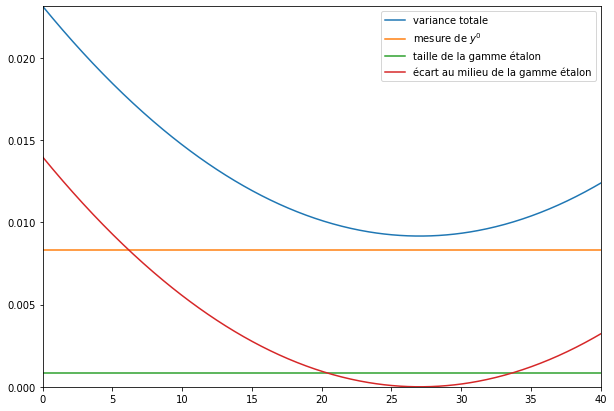

In [11]:
#tracé des points correspondants
fig = plt.figure(figsize=(10,7))
gs = fig.add_gridspec(1, 1,hspace=0.25)
ax1 = fig.add_subplot(gs[0,0])


ax1.plot(y0s,varx0s,marker='',ls='-',label='variance totale')
ax1.plot(y0s,np.ones_like(y0s)*u_y0**2/a**2,marker='',ls='-',label='mesure de $y^0$')
ax1.plot(y0s,np.ones_like(y0s)*u_yi**2 / (y_i.size*a**2),marker='',ls='-',label='taille de la gamme étalon')
ax1.plot(y0s,((y0s-np.average(y_i))/a**2 )**2*u_yi**2/np.sum((x_i-np.average(x_i))**2),marker='',ls='-',label='écart au milieu de la gamme étalon')
ax1.set_xlim(np.min(y0s),np.max(y0s))
ax1.set_ylim(0,np.max(varx0s))
ax1.legend()
plt.show()

On peut voir sur cet exemple qu'il est avantageux de réduire l'incertitude sur la mesure de $y^0$ en augmentant le nombre de mesures $p$. Et qu'il est avantageux de se placer vers le milieu de la gamme étalon (et en analysant un peu plus, d'avoir une gamme étalon la plus étendue possible pour maximiser le dénominateur).